In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point

In [2]:
### generate grid cells of the globe following ERA5 0.25x0.25 degree grid
def generate_grid_cells(lat_start, lat_end, lon_start, lon_end, step):
    latitudes = np.arange(lat_start, lat_end + step, step)
    longitudes = np.arange(lon_start, lon_end + step, step)
    cells = []
    for lat in latitudes[:-1]:  # Exclude the last point to form cells
        for lon in longitudes[:-1]:  # Exclude the last point to form cells
            cells.append(box(lon, lat, lon + step, lat + step))
    return cells

lat_start, lat_end = -90.125, 90.125
lon_start, lon_end = -0.125-180, 359.875-180
step = 0.25

grid_cells = generate_grid_cells(lat_start, lat_end, lon_start, lon_end, step)

In [3]:
print(f"Number of grid cells: {len(grid_cells)}")
print(f"Example grid cell: {grid_cells[0]}")
# print center of the first grid cell
print(f"Center of the first grid cell: {grid_cells[0].centroid}")
print(f"Center of the last grid cell: {grid_cells[-1].centroid}")


Number of grid cells: 1038240
Example grid cell: POLYGON ((-179.875 -90.125, -179.875 -89.875, -180.125 -89.875, -180.125 -90.125, -179.875 -90.125))
Center of the first grid cell: POINT (-180 -90)
Center of the last grid cell: POINT (179.75 90)


In [4]:
# Convert the grid cells to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells,crs="EPSG:4326")

In [5]:
### get land cells 
# get the earth's land surface polygon, read from file
land = gpd.read_file('../sampled_locations/0_25_grid_shp/ne_110m_land/ne_110m_land.shp')
#land = land.to_crs("EPSG:4326")
#grid_gdf = grid_gdf.to_crs("EPSG:4326")
land = land[land['geometry'].type == 'Polygon']
# apply a buffer of 1 grid (0.25 degree) to the land polygons
land_buffered = land.copy()
land_buffered = land_buffered.to_crs("EPSG:4326")
land_buffered['geometry'] = land_buffered['geometry'].buffer(0.5)
# Spatial join between grid cells and land polygons
land_cells = gpd.sjoin(grid_gdf, land, op='intersects')
print(f"Number of land cells: {len(land_cells)}")
land_cells_buffer = gpd.sjoin(grid_gdf, land_buffered, op='intersects')
print(f"Number of land cells after buffer: {len(land_cells_buffer)}")

/tmp/ipykernel_2616/3037039868.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  land_buffered['geometry'] = land_buffered['geometry'].buffer(0.5)
/home/wangyi111/miniconda3/envs/pytorch/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Number of land cells: 356233


/home/wangyi111/miniconda3/envs/pytorch/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Number of land cells after buffer: 393460


In [7]:
# add a column to the grid_gdf to indicate if the cell is land or ocean
grid_gdf['land'] = grid_gdf.index.isin(land_cells.index)
# add a column to the grid_gdf to indicate the center of the cell
grid_gdf['center'] = grid_gdf.centroid
# add index column
grid_gdf['index'] = grid_gdf.index
# replace the geometry column name with 'bbox'
grid_gdf = grid_gdf.rename(columns={'geometry':'bbox'})

/tmp/ipykernel_5475/1368293926.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf['center'] = grid_gdf.centroid


In [18]:
# save the grid_gdf to parquet file
grid_gdf.to_parquet('grid_0_25_globe.parquet')
# read and open the parguet file
#grid_gdf_2 = gpd.read_parquet('grid_0_25_globe.parquet')

# save the grid_gdf to csv
#grid_gdf.to_csv('grid_0_25_globe.csv', index=False)
# read and open the csv file
#grid_gdf_3 = gpd.read_file('grid_0_25_globe.csv')

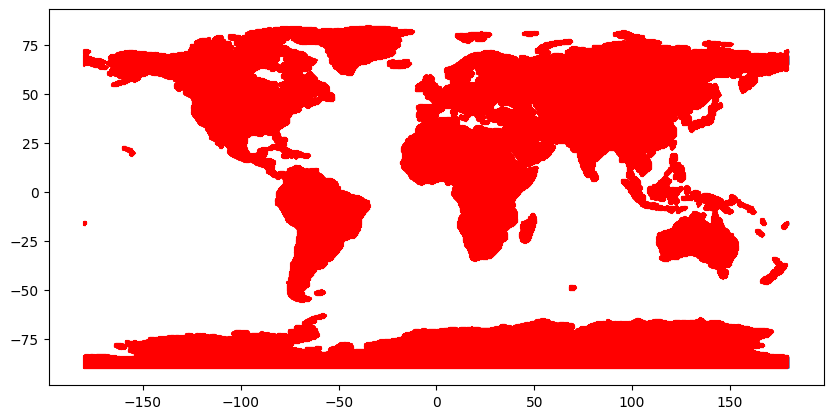

In [8]:
# visualize the grids
# Extract the filtered cells
filtered_cells = land_cells_buffer.geometry
# plot the filtered cells on a world map
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
land.boundary.plot(ax=ax)
filtered_cells.boundary.plot(ax=ax, color='red')
plt.show()

In [25]:
### match land indexs (0-350k) to grid indexs (0-1m)
filtered_centers = [cell.centroid for cell in filtered_cells]
center_gdf = gpd.GeoDataFrame(geometry=filtered_centers, crs="EPSG:4326")

# save points to a csv file with lat, lon columns
center_gdf['lon'] = center_gdf.geometry.x
center_gdf['lat'] = center_gdf.geometry.y
#center_gdf[['lon', 'lat']].to_csv('land_centers_0_25_degree_lon_lat_2.csv', index=True)
# add index column
center_gdf['land_index'] = center_gdf.index
# map center_gdf indices to grid_gdf indices
center_gdf['grid_index'] = land_cells_buffer.index

# drop geometry, save the center_gdf to a csv file
center_gdf = center_gdf.drop(columns=['geometry'])
#center_gdf.to_csv('grid_index_land_buffer.csv', index=False) #! grid ids will be used for data downloading


In [29]:
# ### read sampled s3 coords and match them to grid index
# grid_s3 = gpd.read_file('sampled_coords_0_25_grid_land_s3.csv')

# # add a column to the grid_s3 to indicate the corresponding grid index with the matching from center_gdf
# grid_s3['grid_index'] = -1
# for i, row in grid_s3.iterrows():
#     land_idx = row['idx']
#     land_center = center_gdf[center_gdf['land_index'] == int(land_idx)]
#     grid_idx = land_center['grid_index'].values[0]
#     grid_s3.at[i, 'grid_index'] = grid_idx

# # remove geometry
# grid_s3 = grid_s3.drop(columns=['geometry'])
# # save the grid_s3 to a csv file
# grid_s3.to_csv('grid_index_land_s3.csv', index=False)

### extract grids available for s3
# roughly remove lat >80 and lat <-57
grid_s3 = center_gdf[center_gdf['lat'].apply(lambda x: x < 85 and x > -74)]
grid_s3 = grid_s3[['land_index', 'lon', 'lat', 'grid_index']]
grid_s3.to_csv('grid_index_land_s3.csv', index=False)


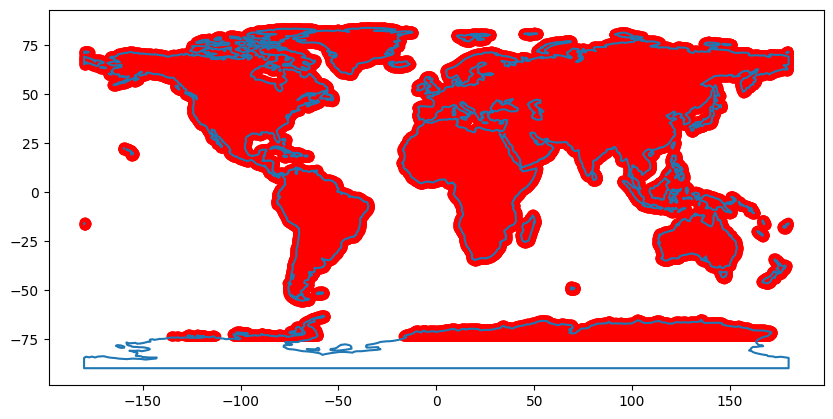

In [30]:
# visualize the grid centers
fig, ax = plt.subplots(figsize=(10, 10))
# create geodataframe from the csv
grid_s3_gdf = gpd.GeoDataFrame(grid_s3, geometry=gpd.points_from_xy(grid_s3.lon, grid_s3.lat))
grid_s3_gdf.plot(ax=ax, color='red')
land.boundary.plot(ax=ax)
plt.show()


In [15]:
### 1. follow ssl4eo-s12 to sample s2 and s1 coords

### 2. read sampled s2 coords and match them to grid index
#df_s2_plus = gpd.read_file('sampled_locations_s2_plus_downloaded_741k.csv',header=None)
df_s2_plus = gpd.read_file('sampled_locations_s2_downloaded_251k.csv',header=None)
grid_gdf_geo = grid_gdf.set_geometry('bbox')
df_s2_plus['geometry'] = df_s2_plus.apply(lambda row: Point(row[1], row[2]), axis=1)
s2_plus_gdf = gpd.GeoDataFrame(df_s2_plus, geometry='geometry', crs="EPSG:4326")
# spatial join between s2_plus_gdf and grid_gdf_geo to get grid ids (0-1m) covering corresponding s2 ids (0-2m)
result_gdf = gpd.sjoin(s2_plus_gdf, grid_gdf_geo, how="left", op="within")
# add two columns to df_s2_plus for center lon and lat
result_gdf['grid_lon'] = result_gdf['center'].apply(lambda x: x.x)
result_gdf['grid_lat'] = result_gdf['center'].apply(lambda x: x.y)

df_s2_plus = result_gdf[['s2_idx', 'longitude', 'latitude', 'index_right', 'grid_lon', 'grid_lat']]
df_s2_plus = df_s2_plus.rename(columns={'index_right': 'grid_id',
                                        's2_idx': 's2_id',
                                        'longitude': 'lon',
                                        'latitude': 'lat'})

# save the result to a csv file
#df_s2_plus.to_csv('sampled_locations_s2_plus_downloaded_741k_grid.csv', index=False, header=True)
df_s2_plus.to_csv('sampled_locations_s2_downloaded_251k_grid.csv', index=False, header=True)


/tmp/ipykernel_2561/1710632703.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_s2_plus['geometry'] = df_s2_plus.apply(lambda row: Point(row[1], row[2]), axis=1)
/home/wangyi111/miniconda3/envs/pytorch/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:
# # extract grids in grid_index_land_s3.csv but not in grid_index_land_s3_old.csv
# import pandas as pd
# # read grid_index_land_s3.csv
# grid_index_land_s3 = pd.read_csv('grid_index_land_s3.csv')
# # read grid_index_land_s3_old.csv
# grid_index_land_s3_old = pd.read_csv('grid_index_land_s3_old.csv')
# # find the difference
# diff = grid_index_land_s3[~grid_index_land_s3['grid_index'].isin(grid_index_land_s3_old['grid_index'])]
# # save the difference to a csv file
# diff.to_csv('grid_index_land_s3_diff.csv', index=False)